# 11. 고급 예측 기법

<br>

## 11.01. 복잡한 계절성

지금까지, 분기별이나 월별 데이터 같이 비교적 단순한 계절성 패턴을 다루었습니다. 하지만, 더 높은 빈도의 시계열에서는 종종 더욱 복잡한 계절성 패턴이 나타납니다. 예를 들면, 일별 데이터에는 일별 패턴이 있을 수 있고 연간 패턴도 있을 수 있습니다. 시간별 데이터에는 보통 3가지 종류의 계절성이 나타납니다: 일별 패턴, 주별 패턴, 그리고 연간 패턴. 주별 데이터 평균적으로  $
365.25
/
7
≈
52.179$
 의 계절성 주기를 갖는 연간 패턴이 보통 나타날 수 있기 때문에 주별 데이터를 다루는 것은 어려울 수 있습니다.
 
**이러한 다중 계절성 패턴은 높은 빈도로 기록된 데이터에서 흔하게 나타납니다. 다중 계절성 패턴이 나타날 수 있는 다른 예제에는 콜센터의 전화량 기록, 일별 병원 방문자 수, ATM에서 현금 인출 요청 수, 전력과 수도 사용량, 웹 사이트 방문자 등이 있습니다.**

지금까지 다룬 대부분의 기법은 이러한 복잡한 계절성을 다룰 수 없습니다. R의 `ts` 클래스는 보통 정수 값을 가진다고 가정하는 1가지 계절성만 다룰 수 있습니다.

**이러한 시계열을 다루기 위해, 다중 계절성 시계열을 다루는 `msts` 클래스를 사용할 것입니다.** 이것을 이용하여 관련 있을 수 있는 주기 값 전체를 정할 수 있습니다. 이 클래스는 정수가 아닌 주기도 다룰 수 있을 정도로 유연합니다.

**유연성이 있더라도, 이러한 주기 전부를 넣을 필요가 없을 수 있습니다. 데이터에서 가장 잘 나타나는 하나만 필요할 수 있습니다. 예를 들면, 180일 데이터만 가지고 있을 때, 연도 계절성을 무시할 수 있습니다. 자연 현상을 측정한 데이터라면(예: 온도), 아마도 안전하게 주별 계절성도 무시할 수 있을 것입니다.**

아래 그림의 윗 부분은 33주 동안 주중 오전 7시부터 오후 9시 5분까지 5분 간격으로 소매 은행에 걸려오는 통화의 수를 나타냅니다. 아래 부분은 같은 시계열의 처음 3주를 나타냅니다. 주기 169인 (하루에 5분 시간 간격이 169개 있습니다) 일별 계절성 패턴이 강하게 나타나고, 주기 $ 
169
×
5
=
845$
 인 주별 계절성 패턴이 약하게 나타납니다. (월요일에는 통화의 수가 주중 나머지 날보다 높게 나타나는 경향이 있습니다.) 더 긴 시계열 데이터를 이용할 수 있다면, 연간 계절성 패턴도 관측할 수 있겠습니다.

In [2]:
library(tidyverse)
library(fpp3)
library(fpp2)
library(fpp)
library(forecast)

In [7]:
calls %>% head
calls %>% length

A Time Series:
[1] 111 113  76  82  91  87
attr(,"msts")
[1] 169 845

[1] 27716

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


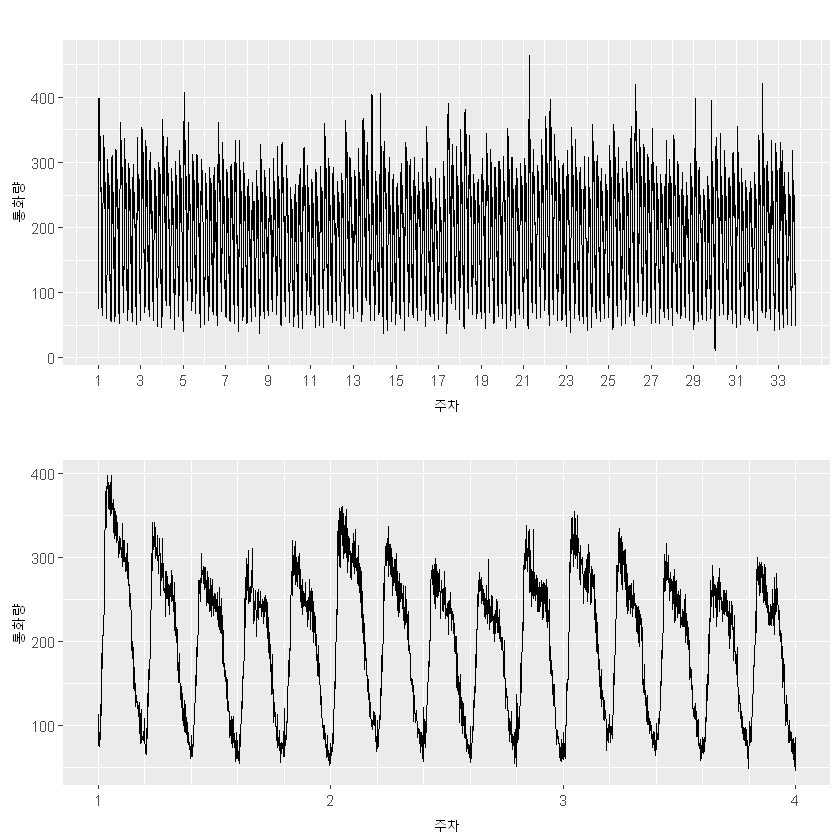

In [3]:
p1 <- autoplot(calls) +
  ylab("통화량") + xlab("주차") +
  scale_x_continuous(breaks=seq(1,33,by=2))

p2 <- autoplot(window(calls, end=4)) +
  ylab("통화량 ") + xlab("주차") +
  scale_x_continuous(minor_breaks = seq(1,4,by=0.2))

gridExtra::grid.arrange(p1,p2)

<br>

### 다중 계절성 주기를 고려하는 STL

`mstl()` 함수는 여러 계절성을 고려하도록 `stl()`을 변형한 것입니다. 결과값으로 다중 계절성 성분, 추세, 나머지 성분을 돌려줍니다.

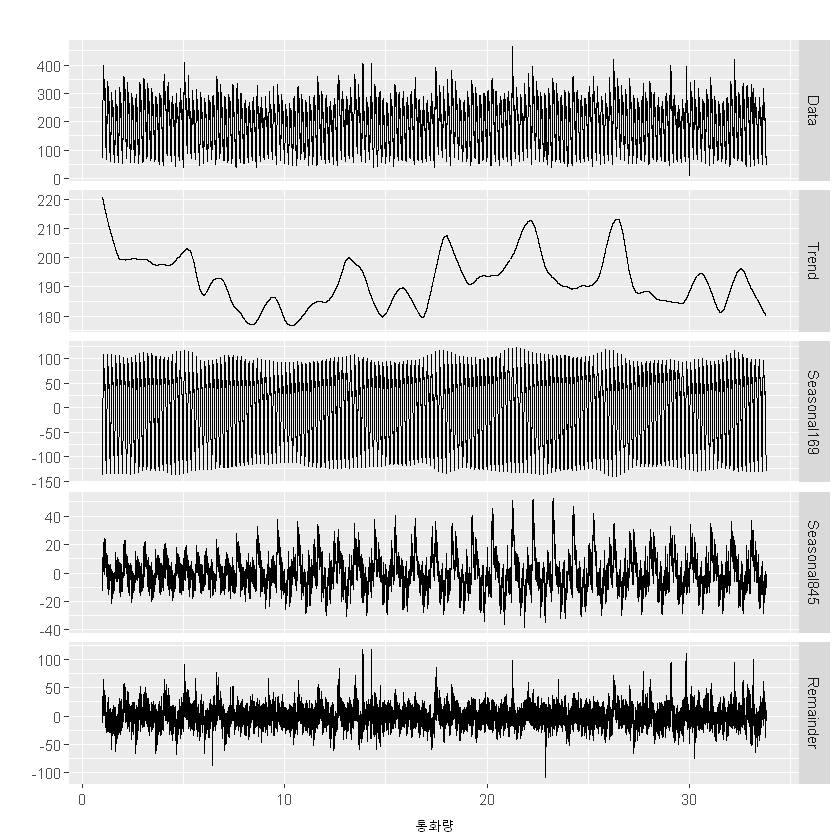

In [8]:
calls %>% mstl() %>%
  autoplot() + xlab("통화량")

두 가지 계절성 패턴이 나타납니다. **하루에 대한 것(3번째 패널)과 주에 대한 것(4번째 패널)입니다.** 이 그래프를 적절하게 해석하려면, 수직 눈금을 살펴보는 것이 중요합니다. **이 경우에는, 데이터에서 작은 추세가 나타나고 주별 계절성이 약해서 다른 성분에 비해 추세와 주별 계절성이 상대적으로 좁은 범위로 나타납니다.**

이러한 분해를 계절성 단순(naïve) 기법을 이용하여 계절 성분 각각을 예측할 때와 ETS (또는 몇몇 사용자가 정한 다른 기법)를 이용하여 계절성으로 조정된 데이터를 예측할 때 사용할 수 있습니다. `stlf()` 함수가 이 작업을 자동으로 할 것입니다.

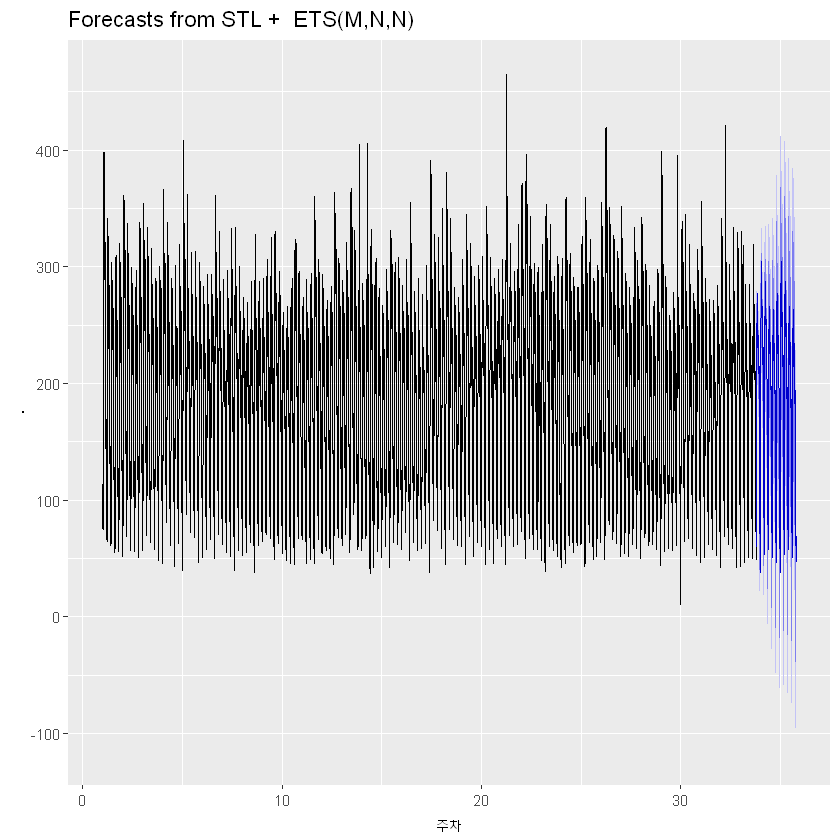

In [9]:
calls %>%  stlf() %>%
  autoplot() + xlab("주차")

<br>

### 다중 계절성 주기를 고려하는 동적 조화 회귀

앞의 장에서 한 것처럼 푸리에 항을 이용하여 다중 계절성을 다룰 수 있습니다(5.4 절과 9.5 절을 참조하시길 바랍니다). 다중 계절성이 있기 때문에, 각 계절성 주기에 푸리에 항을 추가할 필요가 있습니다. 이 경우에, 계절성 주기는 169와 845이고, 따라서  $k=1,2,\dots$에 대한 푸리에 항의 형태는 다음과 같습니다.

$$\sin\left(\frac{2\pi kt}{169}\right), \quad
  \cos\left(\frac{2\pi kt}{169}\right), \quad
  \sin\left(\frac{2\pi kt}{845}\right), \quad  \text{and}  \quad
  \cos\left(\frac{2\pi kt}{845}\right),$$
  
`fourier()` 함수로 이러한 항을 생성할 수 있습니다.

ARMA 오차 구조를 고려하는 동적 조화 회귀 모델을 맞출 것입니다. AICc를 최소화하기 위해 각 계절성 주기에 대한 푸리에 항의 전체 숫자가 선택될 것입니다. 예측값과 예측 구간이 양수로 유지되는지 확인하기 위해 로그 변환(`lambda=0`)을 사용할 것입니다.

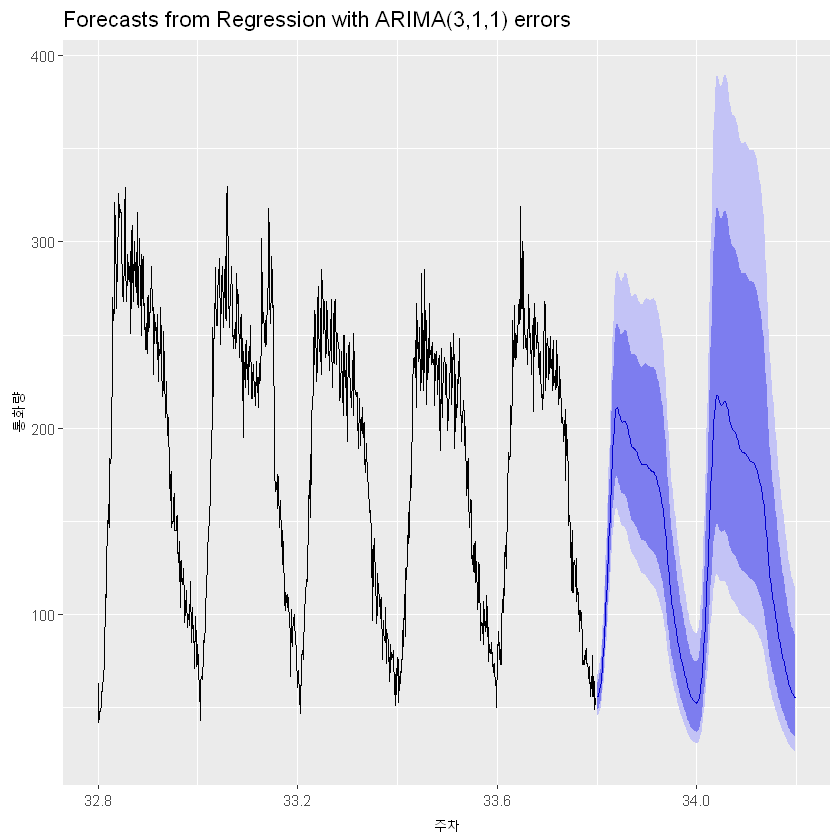

In [10]:
fit <- auto.arima(calls, seasonal=FALSE, lambda=0,
         xreg=fourier(calls, K=c(10,10)))

fit %>%
  forecast(xreg=fourier(calls, K=c(10,10), h=2*169)) %>%
  autoplot(include=5*169) +
    ylab("통화량") + xlab("주차")

이것은 40개의 매개변수를 포함하는 큰 모델입니다: 4개의 ARMA 계수, 주기 169에 대한 20개의 푸리에 계수, 주기 845에 대한 16 개의 푸리에 계수. 주기 169의 항과 겹치기 때$문에 ( 
845
=
5
×
169$
 ) 주기 845에 대한 모든 푸리에 항은 사용하지 않습니다.

<br>

### TBATS 모델

De Livera, Hyndman, & Snyder (2011) 가 개발한 또 다른 접근 방식에서는 지수 평활 상태 공간 모델(exponential smoothing state space model)과 박스-칵스(Box-Cox) 변환을 고려하는 푸리에 항의 조합을 완벽히 자동화된 방식으로 사용합니다. 다른 자동화된 모델링 체계가 그렇듯이, 안 좋은 결과를 내는 경우가 있을 수 있습니다만, 몇 가지 상황에서 유용한 접근 방식이 될 수 있습니다.

**조화 회귀 항은 계절성 패턴이 변하지 않고 주기적으로 반복해서 나타나도록 합니다만, TBATS 모델은 계절성이 TBATS 모델에서 시간에 따라 느리게 변할 수 있다는 점에서 동적 조화 회귀와는 다릅니다.** 

**하지만 TBATS 모델의 한 가지 단점은 특별히 긴 시계열을 추정하는데 느릴 수 있다는 것입니다. 따라서 시간을 아끼기 위해 calls 데이터의 일부분을 다룰 것입니다.**

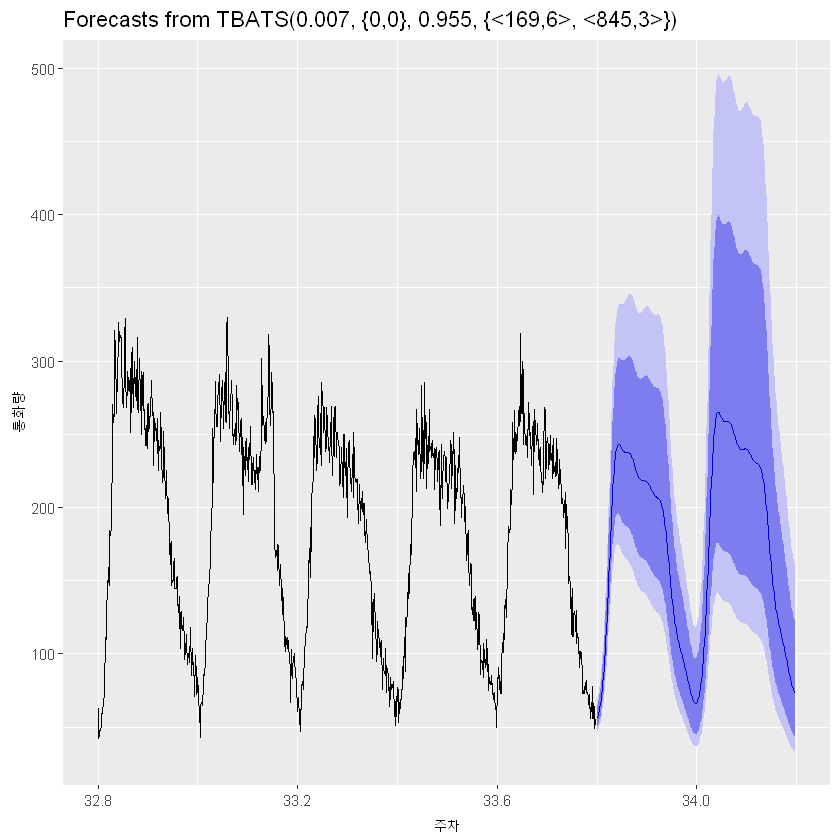

In [11]:
calls %>%
  subset(start=length(calls)-2000) %>%
  tbats() -> fit2

fc2 <- forecast(fit2, h=2*169)

autoplot(fc2, include=5*169) +
  ylab("통화량") + xlab("주차")

여기에서 나타나는 예측구간은 너무 넓습니다. 안타깝게도 TBATS 모델에서는 종종 이런 상황이 벌어지기도 합니다.



<br>

### 공변량이 있는 복잡한 계절성

동적 조화 회귀(dynamic harmoic regression) 모델에는 공변량(covariate)이 들어갈 수 있긴해도, TBATS 모델은 공변량을 허용하지 않습니다. 이러한 모델을 보통 전력 수요 모델링에 적용합니다.

아래 그림은 2014년에 호주 빅토리아 주에서 매 30분마다 전력 수요를 빅토리아 주의 가장 큰 도시인 멜버른에 대해 같은 기간의 온도에 따라 나타낸 것입니다.



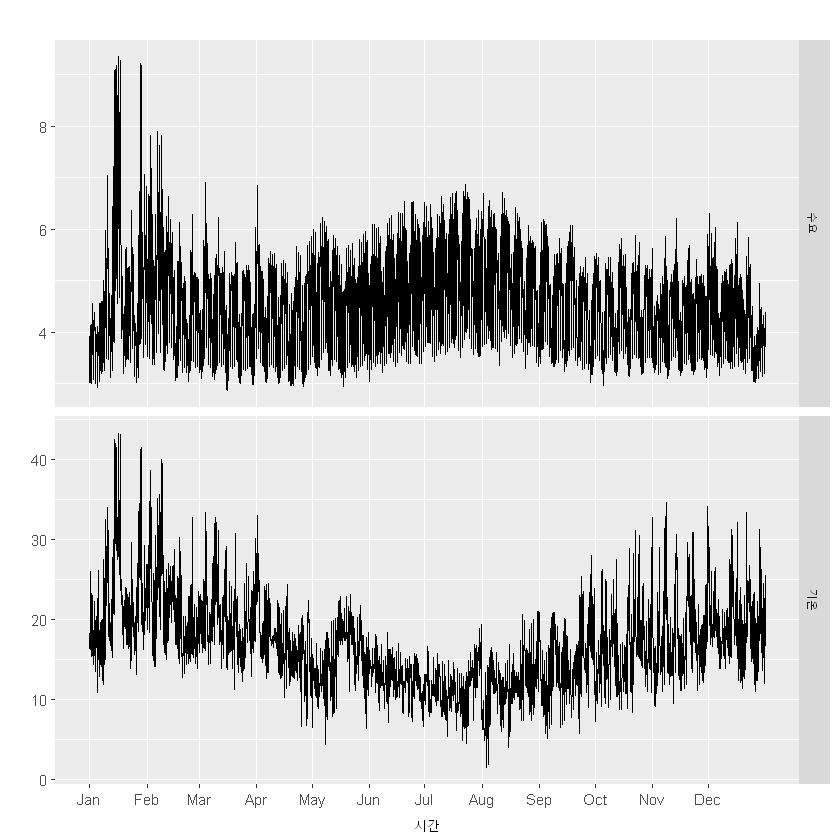

In [12]:
colnames(elecdemand) <- c("수요","WorkDay","기온")

autoplot(elecdemand[,c("수요","기온")],
    facet=TRUE) +
  scale_x_continuous(minor_breaks=NULL,
    breaks=2014+
      cumsum(c(0,31,28,31,30,31,30,31,31,30,31,30))/365,
    labels=month.abb) +
  xlab("시간") + ylab("")

In [13]:
colnames(elecdemand) <- c("Demand","WorkDay","Temperature") 

<br>

전력 수요를 온도에 따라 그리면 (아래 그림), 기온이 낮을 때는 (난방 때문에) 수요가 증가하고, 기온이 높을 때는 (냉방 때문에) 수요가 증가하는 둘 사이의 비선형 관계가 나타납니다.

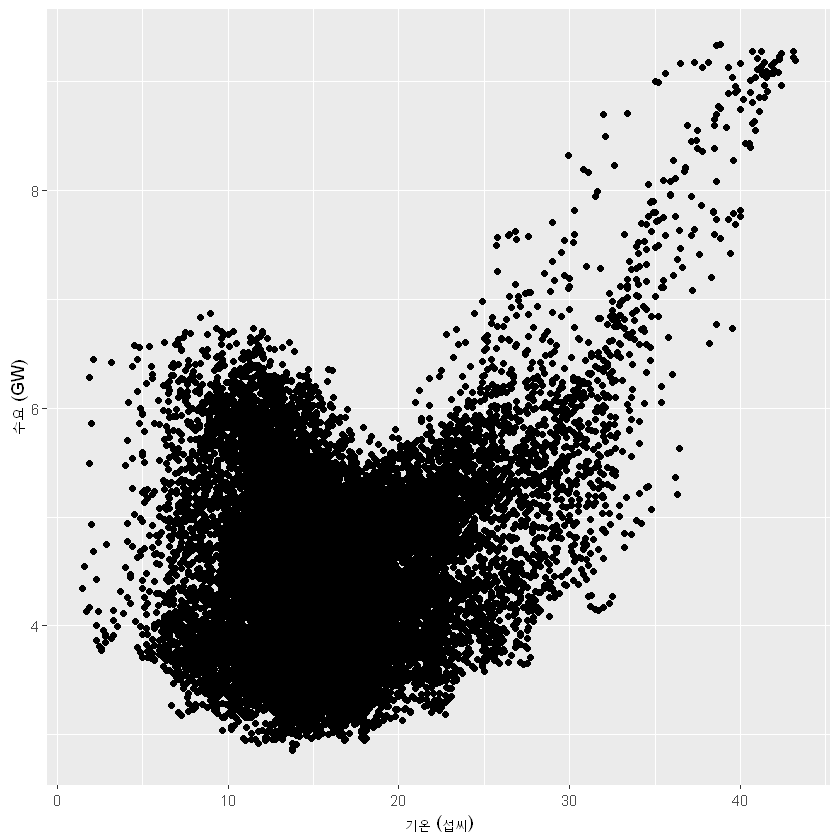

In [14]:
elecdemand %>%
  as.data.frame() %>%
  ggplot(aes(x=Temperature, y=Demand)) + geom_point() +
    xlab("기온 (섭씨)") +
    ylab("수요 (GW)")

(섭씨 18도에 있는 매듭을 포함하는) 온도의 단계별 선형 함수와 일별 계절성 패턴을 허용하기 위한 회귀 항을 고려하는 회귀 모델을 맞출 것입니다.



In [15]:
cooling <- pmax(elecdemand[,"Temperature"], 18)

fit <- auto.arima(elecdemand[,"Demand"],
         xreg = cbind(fourier(elecdemand, c(10,10,0)),
               heating=elecdemand[,"Temperature"],
               cooling=cooling))

예측변수(predictor variable)의 미래 값이 필요하기 때문에 이러한 모델로 예측하는 것은 어려운 일입니다. 푸리에 항의 미래값은 계산하기 쉽습니다만, 미래 온도값은 물론 알 수 없습니다. 한 주 앞까지만 예측하는데 관심이 있다면, 기상학적인 모델로부터 얻은 기온 예측값을 사용할 수 있습니다. 다른 방법으로는, 시나리오 예측을 사용하여 (4.5 절), 가능한 온도 패턴을 넣는 방법도 있겠습니다. 대신에, 시나리오 예측을 사용하여 가능한 기온 패턴을 넣을 수도 있습니다. 다음 예제에서는, 가능한 미래 수요값을 생성하기 위해 마지막 2주의 온도 값을 반복하여 사용합니다.



Warning message in forecast.forecast_ARIMA(fit, xreg = cbind(fourier(temps, c(10, :
"xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order."


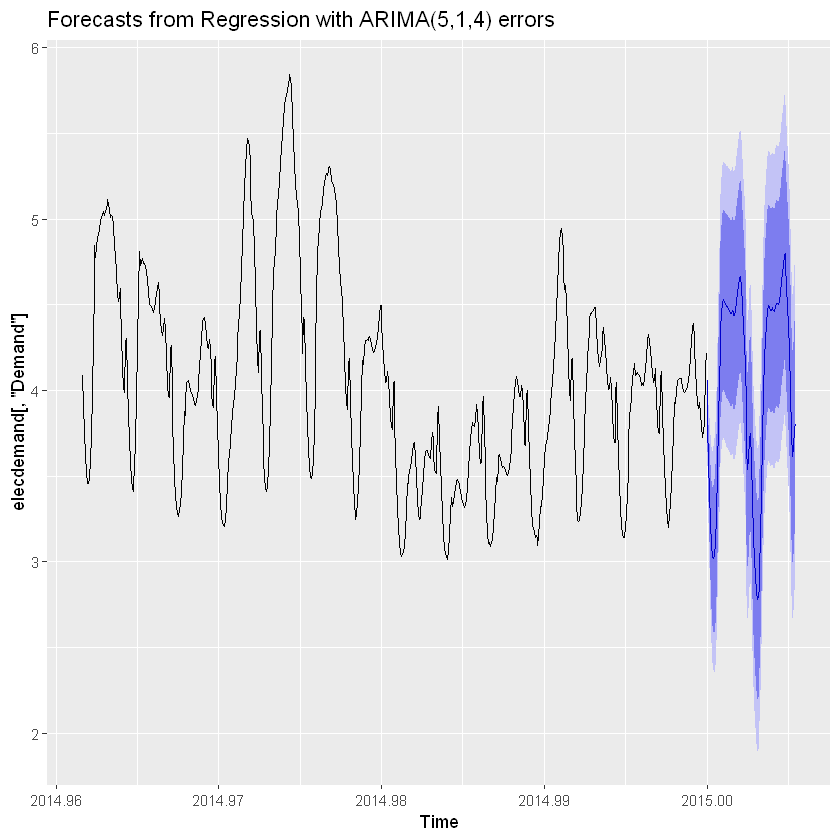

In [16]:
temps <- subset(elecdemand[,"Temperature"],
          start=NROW(elecdemand)-2*48+1)

fc <- forecast(fit,
        xreg=cbind(fourier(temps, c(10,10,0)),
          heating=temps, cooling=pmax(temps,18)))

autoplot(fc, include=14*48)

단기 예측값이 그럴듯해보여도, 이건 복잡한 과정을 설명하기 위해 대강 만든 모델입니다. 잔차(residual)는 이 모델이 잡아내지 못한 정보가 여전히 많다는 것을 나타냅니다.




	Ljung-Box test

data:  Residuals from Regression with ARIMA(5,1,4) errors
Q* = 738497, df = 3495, p-value < 2.2e-16

Model df: 9.   Total lags used: 3504



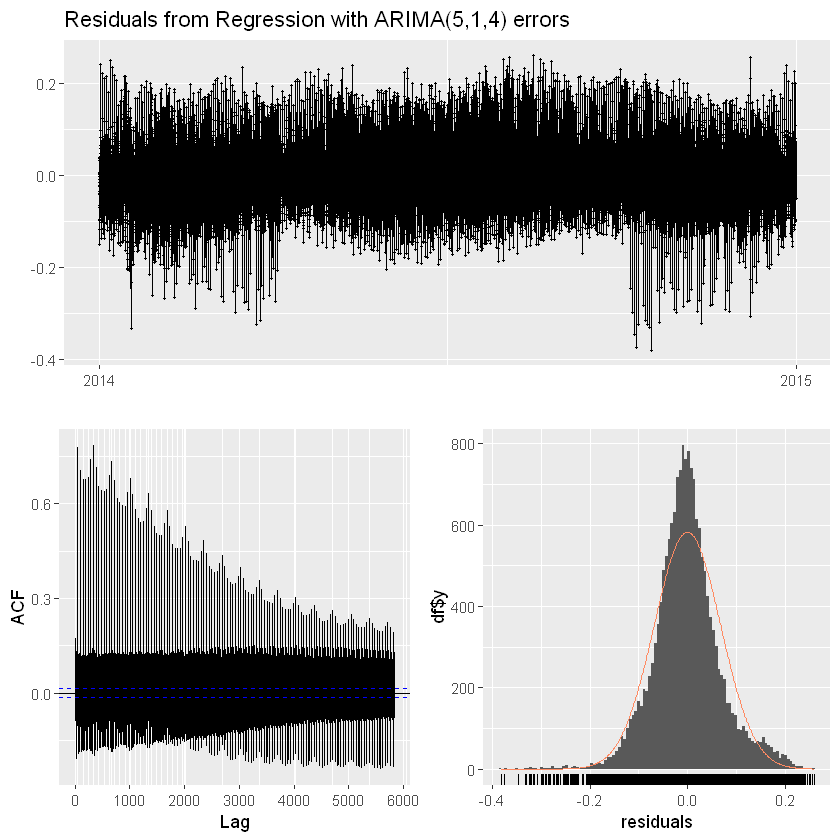

In [17]:
checkresiduals(fc)

<br>

## 11.02. 벡터 자기회귀

지금까지 다룬 모델의 한 가지 한계는 단 방향 관계(unidirectional relationship)만 있다는 것입니다. **즉, 목적 예상변수(forecast variable)는 예측변수(predictor variable)의 영향을 받지만, 반대의 경우는 영향을 받지 않습니다. 하지만, 반대 경우도 허용해야만 하는 많은 경우가 있습니다. 이러한 경우에는 모든 변수가 서로 영향을 미칩니다.** 9.2 절에서 개인 소비 지출의 변화( $
C_
t$
 )는 개인 가처분 소득의 변화( $
I_
t$
 )에 기초하는 예측값이었습니다. 하지만, 이 경우에 양 방향 관계(bi-directional relationship)가 더 적절할 수 있습니다. $ 
I_
t$
 의 증가가  $
C_
t$
 의 증가로 이어질 수 있고 반대로도 가능합니다.

2008년부터 2009년 세계 경제 위기 기간 동안에 호주에서 이러한 상황이 일어났습니다. 호주 정부는 2008년 12월 크리스마스 기간의 일시적인 소비를 위해 현금 지불을 포함하는 경기 부양책을 발표했습니다. 결과적으로, 소매 업체는 판매량이 늘어나서 경제가 활성화되었습니다. 결과적으로 소득이 증가했습니다.

**이러한 되먹임 관계(feedback relationship)는 벡터 자기회귀(VAR) 체계에서 허용됩니다. 이 체계에서는, 모든 변수를 대칭적으로 다룹니다.** 

**마치 이러한 값이 서로에게 똑같이 영향을 주는 것처럼 이러한 값 모두를 모델링합니다. 더욱 형식적인 전문용어로는, 모든 변수를 이제 “내생적(endogenous)”으로 다룬다고 합니다.** 이것을 나타내기 위해, 표기법을 바꿔서 모든 변수를  $
y$
 로 씁니다.  $
y_{
1
,
t}$
 는 변수  $
y_
1$
 의  $
t$
 번째 관측값,  $
y_{
2
,
t}$
 는 변수  $
y_
2$
 의$  
t$
 번째 관측값, 나머지도 마찬가지입니다.

**VAR 모델은 시계열의 벡터를 예측하는 단변량(univariate) 자기회귀 모델의 일반적인 형태입니다 시스템에서 고려하는 변수 당 하나의 식을 포함합니다. 각 식의 우변은 상수와 시스템의 모든 변수의 시차(lag)를 포함합니다. 단순하게 두기 위해, 하나의 시차가 있는 두 변수 VAR을 다룰 것입니다. 2차원 VAR(1)은 다음과 같이 씁니다.**


\begin{align}
  y_{1,t} &= c_1+\phi _{11,1}y_{1,t-1}+\phi _{12,1}y_{2,t-1}+e_{1,t} \tag{11.1}\\
  y_{2,t} &= c_2+\phi _{21,1}y_{1,t-1}+\phi _{22,1}y_{2,t-1}+e_{2,t}, \tag{11.2}
\end{align}

여기에서  $
e_{
1
,
t}$
 와  $
e_{
2
,
t}$
 은 동시에 상관관계를 가질 수 있는 백색잡음(white noise) 과정입니다. 계수  $
ϕ_{
i
j
,
ℓ}$
 는  $
y_
i$
 에 대한 변수 $ 
y_
j$
 의$  
ℓ$
 번째 시차의 영향을 잡아내고, 계수  $
ϕ_{
i
i
,
ℓ}$
 는 변수  $
y_
i$
 의$  
ℓ$
 번째 시차의 영향을 잡아냅니다.

**모델링한 시계열이 정상성(stationarity)을 나타내면, VAR로 직접 데이터를 맞춰서 예측합니다(“수준의 VAR”로 알려진). 시계열이 정상성을 나타내지 않으면, 정상성을 나타내도록 데이터에서 차분(difference)을 구하고, VAR 모델을 맞춥니다(차분의 VAR로 알려진). 두 경우 모두, 최소 제곱 원리(least square principle)를 이용하는 식으로 모델을 추정합니다. 각 식에서  $
e_{i
,
t}$
  값의 합을 최소화하여 매개변수를 추정합니다.**

이 책에서 다루는 범위를 벗어나서 여기에서는 자세히 살펴보지는 않을 다른 가능성도 있습니다. 이 방법에서는 시계열이 정상성을 나타내지 않을 수 있지만, 서로 결합되어 있습니다. 이것은 정상성을 나타내는 선형 결합이 존재한다는 의미입니다. 이 경우에는 오차 보정 방법(부통 벡터 에러 보정 모델로 부르는)을 포함하는 VAR 기법이 들어가야만 하고 최소 제곱 추정 대신에 다른 추정 기법을 사용해야 합니다.

반복적으로 VAR로부터 예측값을 얻습니다. VAR은 시스템에 있는 각 변수에 대한 예측값을 냅니다. 이 과정을 설명하기 위해, 식 (11.1)–(11.2) 에서 설명한 시간  
T
 까지의 모든 관측값에 대해 2차원 VAR(1)을 맞춘 것을 가정합니다. 그러면 다음의 식으로부터 한-단계-앞 예측값을 얻습니다.
 
$$\begin{align*}
  \hat y_{1,T+1|T} &=\hat{c}_1+\hat\phi_{11,1}y_{1,T}+\hat\phi_{12,1}y_{2,T} \\
  \hat y_{2,T+1|T} &=\hat{c}_2+\hat\phi _{21,1}y_{1,T}+\hat\phi_{22,1}y_{2,T}.
\end{align*}$$

이것은 0으로 둔 오차와 매개변수를 추정값으로 바꾼 것을 제외하고는 (11.1)–(11.2)와 같은 형태입니다.  $
h
=
2$
 에 대해, 다음의 식으로부터 예측값을 얻습니다.

$$\begin{align*}
  \hat y_{1,T+2|T} &=\hat{c}_1+\hat\phi_{11,1}\hat y_{1,T+1}+\hat\phi_{12,1}\hat y_{2,T+1}\\
  \hat y_{2,T+2|T}&=\hat{c}_2+\hat\phi_{21,1}\hat y_{1,T+1}+\hat\phi_{22,1}\hat y_{2,T+1}.
\end{align*}$$

또 다시, 0으로 둔 오차, 매개변수를 추정값으로 바꾼 것,  $
y_
1$
 과  $
y_
2$
 의 알려지지 않은 값을 제외하고는 (11.1)–(11.2)와 같은 형태입니다. 이러한 방법으로 미래의 모든 시점에 대해 이 과정을 반복할 수 있습니다.

**VAR을 이용하여 예측할 때 두 가지 판단을 해야합니다. ( $
K$
 로 쓰는) 얼마나 많은 변수와 ( $
p$
 로 쓰는) 얼마나 많은 시차값이 시스템에 있어야 하는지입니다. VAR에서 추정할 계수의 수는  $
K
+
p
K^
2$
 와 같습니다(또는 식 하나 당  $
1
+
p
K$
 개). 예를 들면,  $
K
=
5$
  변수와  $
p
=
3$
  시차값이 있는 VAR에 대해, 추정할 전체 80개의 계수에 대해 식 하나 당 16개의 계수가 있습니다. 추정할 계수가 많아지면, 예측에 들어오는 추정 오차가 커집니다.**

<br>


실제로는  $
K$
 를 작게 두고 서로 상관관계가 있는 (예측할 때 쓸모 있는) 변수만 포함합니다. 넣을 시차값(lag)의 수를 고를 때 흔히 정보기준(information criteria)을 사용합니다.

R의 `vars` 패키지에는 VAR 모델이 구현되어 있습니다. 이 패키지에는 4가지 서로 다른 정보 기준(AIC, HQ, SC, FPE)을 가지고 시차 $ 
p$
  값의 수를 고르기 위한 VARselect() 함수가 있습니다. AIC는 이전에 다루었고, SC는 단순히 BIC의 다른 이름입니다(SC는 이 방법을 제안한 기던 슈와르츠(Gideon Schwarz) 이후에 불렀던 슈와르츠 기준(Schwarz Criterion)의 약자입니다). HQ는 하난-퀸(Hannan-Quinn) 기준이고 FPE는 “최종 예측 오차(Final Prediction Error)”입니다.
  
AIC를 이용할 때는 시차 값의 수가 크게 선택되는 경향이 있으니 조심해야합니다. 대신에 VAR 모델에 대해서 BIC를 사용하는 것을 추천합니다.

VAR 모델은 이론적이지 않다고 비판 받습니다. 즉, 이론적인 구조를 식에 반영하는 몇몇 경제학적 이론에 기초하여 세운 것이 아닙니다. 모든 변수는 시스템 안의 다른 모든 변수에 영향을 준다는 가정을 하기 때문에 추정한 계수를 해석하는 것이 어렵습니다. 그렇긴 하지만, VAR 모델은 여러 상황에서 유용합니다:

1. **분명한 해석이 필요 없을 때 관련된 변수의 모임을 예측할 때;**

2. **(그랑거(Granger) 인과율(causality) 검정에 기초하여) 한 변수가 다른 것을 예측 할 때 유용한지 판단할 때;**

3. **충격 반응 분석(impulse response analysis), 한 변수가 다른 한 변수의 갑작스럽지만 일시적인 변화에 반응하는 것을 분석할 때;**

4. **예측 분산 분해를 예측할 때, 다른 변수의 효과의 결과가 각 변수의 예측 분산의 비율이 될 때.**


<br>

### 예제: 미국 소비 예측에 대한 VAR 모델



In [43]:
#install.packages("vars_1.5-9.tar.gz")

In [22]:
library(vars)

In [25]:
VARselect(uschange[,1:2], lag.max=8, type="const")[["selection"]]

AIC(n)  HQ(n)  SC(n) FPE(n) 
     5      1      1      5

출력 결과는 vars 패키지에서 이용할 있는 각 정보 기준으로 고른 시차 길이를 나타냅니다. AIC로 고른 VAR(5)와 BIC로 고른 VAR(1) 사이에 큰 차이가 있습니다. 이런 차이는 그렇게 특별한 것이 아닙니다. 결과적으로 BIC로 고른 VAR(1)을 먼저 맞춥니다.

In [27]:
var1 <- VAR(uschange[,1:2], p=1, type="const")
serial.test(var1, lags.pt=10, type="PT.asymptotic")


	Portmanteau Test (asymptotic)

data:  Residuals of VAR object var1
Chi-squared = 49.102, df = 36, p-value = 0.07144

$serial

	Portmanteau Test (asymptotic)

data:  Residuals of VAR object var1
Chi-squared = 49.102, df = 36, p-value = 0.07144



In [28]:
var2 <- VAR(uschange[,1:2], p=2, type="const")
serial.test(var2, lags.pt=10, type="PT.asymptotic")


	Portmanteau Test (asymptotic)

data:  Residuals of VAR object var2
Chi-squared = 47.741, df = 32, p-value = 0.03633

$serial

	Portmanteau Test (asymptotic)

data:  Residuals of VAR object var2
Chi-squared = 47.741, df = 32, p-value = 0.03633



단변수(univariate) ARIMA 기법과 비슷하게, 포트맨토(portmanteau) 검정을 이용하여 잔차(residual)에 상관관계(correlation)가 없는지 확인합니다. VAR(1)과 VAR(2) 둘 다 약간의 잔차 계열상관(residual serial correlation)이 있습니다. 따라서 VAR(3)으로 맞춥니다.



In [30]:
var3 <- VAR(uschange[,1:2], p=3, type="const")
serial.test(var3, lags.pt=10, type="PT.asymptotic")


	Portmanteau Test (asymptotic)

data:  Residuals of VAR object var3
Chi-squared = 33.617, df = 28, p-value = 0.2138

$serial

	Portmanteau Test (asymptotic)

data:  Residuals of VAR object var3
Chi-squared = 33.617, df = 28, p-value = 0.2138



이 모델에 대한 잔차(residual)는 계열상관에 대한 검증을 통과합니다. VAR(3)로 낸 예측값을 아래 그림에 나타냈습니다.



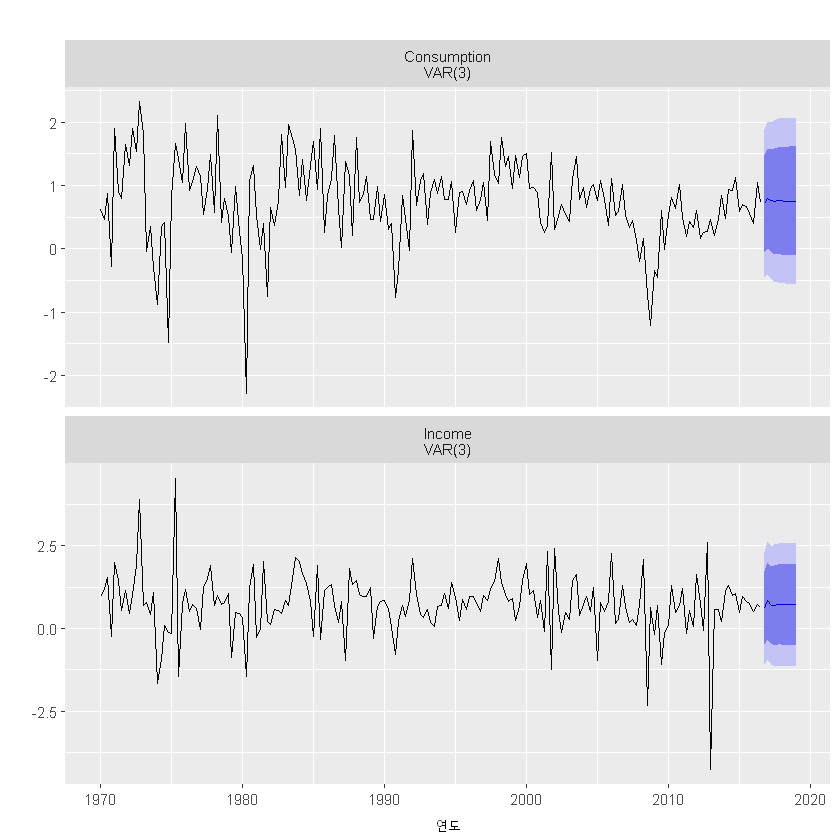

In [31]:
forecast(var3) %>%
  autoplot() + xlab("연도")

<br>

## 11.03. 신경망 모델

인공 신경망 모델(neural network model)은 단순한 수학적 뇌 모델에 기초하는 예측 기법입니다. 이러한 기법으로 반응 변수(response variable)와 예측변수(predictor variable) 사이의 복잡한 비선형 관계를 다룰 수 있습니다.

<br>

### 신경망 구조

신경망을 계층으로 구성된 “신경 세포(neuron)”의 연결망으로 생각할 수 있습니다. 예측변수(predictor variable)(또는 입력값-input)가 밑바닥 계층을 이루고 예측값(forecast)(또는 출력값-output)이 꼭대기 계층을 이룹니다. “숨겨진 신경 세포(hidden neuron)”을 포함하는 중간 계층이 있을 수 있습니다.

단순한 연결망에는 숨겨진 계층이 없고 이러한 경우는 선형 회귀와 같습니다. 아래 그림은 4개의 예측변수(predictor variable)를 고려하는 선형 회귀의 신경망 버전입니다. 이러한 예측변수(predictor variable)에 붙은 계수를 “가중치(weight)”이라고 부릅니다. 이러한 입력값의 선형 결합으로 예측값을 얻습니다. MSE 같은 비용 함수를 최소화하는 “학습 알고리즘(learning algorithm)”을 이용하여 신경망 틀에서 가중치를 고릅니다. 물론, 이 단순한 예제에서는 훨씬 더 효과적으로 모델을 학습시키는 기법인 선형 회귀를 사용할 수 있습니다.

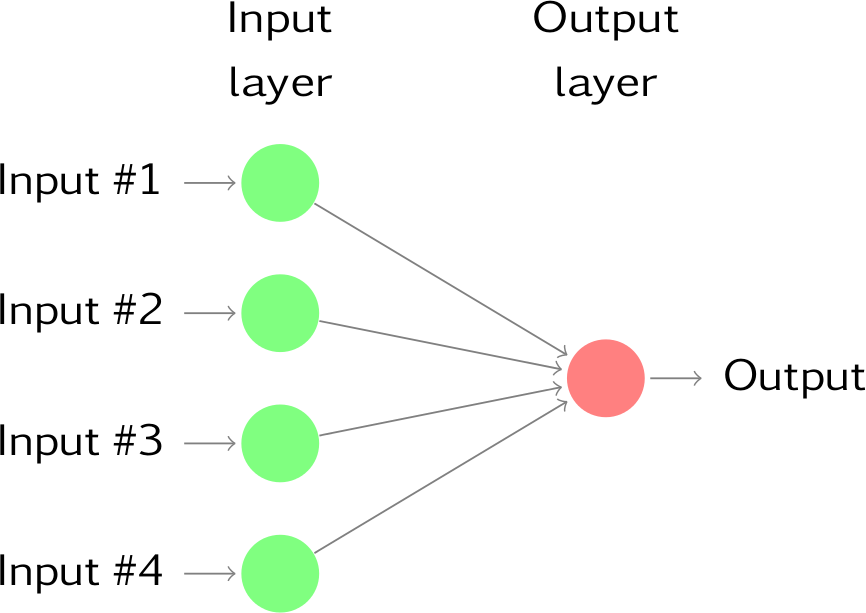


<br>

숨겨진 신경 세포가 있는 중간 계층을 넣으면, 신경망이 비선형이 됩니다. 아래 그림은 단순한 예제를 나타냅니다.

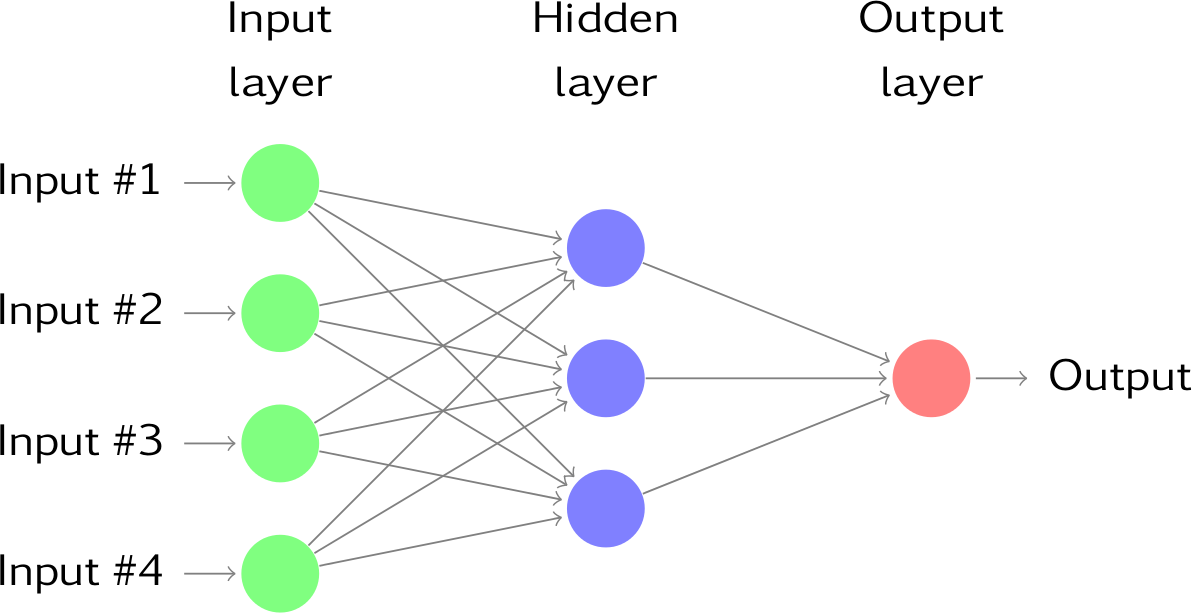

이것을 다층 앞먹임 연결망(multilayer feed-forward network)으로 부릅니다. 여기에서 각 계층의 마디(node)는 이전의 계층에서부터 입력값을 받습니다. 한 계층에서 마디의 출력값은 다음 계층의 입력값이 됩니다. 각 마디의 입력값은 가중 선형 결합(weighted linear combination)으로 결합됩니다. 결과는 출력되기 전에 비선형 함수에 의해 수정됩니다. 예를 들면, 그림에서 숨겨진 신경 세포 $j$로 들어가는 입력값은 다음과 같이 주어지는 선형 결합입니다.

$$z_j = b_j + \sum_{i=1}^4 w_{i,j} x_i.$$

숨겨진 계층에서, 이것은 다음 계층에 입력값이 되기 위해 다음의 S자 모양의 함수 같은 비선형 함수를 이용하여 수정됩니다.

$$s(z) = \frac{1}{1+e^{-z}},$$

극단적인 입력값의 효과를 줄이는 경향이 있습니다. 그래서 연결망이 이상값에 의한 영향에 잘 견디도록 합니다.

매개변수 $b_1,b_2,b_3$와 $w_{1,1},\dots,w_{4,3}$은 데이터로부터 “학습된(learned)” 것입니다. 가중치의 값은 종종 너무 커지지 않도록 제한됩니다. 가중치를 제한하는 매개변수를 “감쇠 매개변수(decay parameter)”라고 부르고 종종 0.1로 둡니다.

처음에는 가중치 값을 무작위로 주고, 관측된 데이터를 가지고 업데이트합니다. 그래서, 신경망으로 낸 예측값에는 무작위성이 있습니다. 따라서, 다른 무작위 시작점을 가지고 연결망을 여러번 훈련시키고, 결과들의 평균을 구합니다.

숨겨진 계층의 수와 각 숨겨진 계층의 마디의 수를 반드시 미리 정해야 합니다. 이 장의 뒷 부분에서 교차-검증(cross-validation)으로 이러한 값을 어떻게 정할 수 있는지 다루겠습니다.



<br>

### 신경망 자기 회귀

시계열 데이터을 가지고, 선형 자기 회귀 모델에서 시차값을 사용한 것처럼(8 장), 시계열의 시차값을 신경망의 입력값으로 사용할 수 있습니다. 이것을 신경망 자기 회귀 또는 NNAR 모델이라고 부르겠습니다.

이 책에서는, 1개의 숨겨진 계층이 있는 앞먹임 연결망(feed-forward network)만 다루고, 숨겨진 계층에서 $p$개의 시차 입력값과 $k$개의 마디가 있다는 것을 나타내는 NNAR($p,k$)) 기호를 사용합니다. 예를 들어, NNAR(9,5) 모델은 출력값 $y_t$을 예측하기 위해 마지막 9개의 관측값 $(y_{t-1},y_{t-2},\dots,y_{t-9})$을 입력값으로 사용하고 숨겨진 계층에 5개의 신경 세포가 있는 신경망입니다. NNAR($p,0$)) 모델은 ARIMA($p,0,0$)) 모델과 같지만, ARIMA에서 정상성이 있도록 하는 제한조건에 대한 매개변수가 없습니다.

계절성 데이터를 가지고, 같은 계절의 마지막 관측값을 입력값으로 넣는 것도 유용합니다. 예를 들면, NNAR(3,1,2)$_12$  모델은 입력값 $y_{t-1}, y_{t-2}, y_{t-3}, y_{t-12}$이 있고, 숨겨진 계층에 2개의 신경 세포가 있습니다. 더 일반적으로는, NNAR($p, P, k)_m$ 모델에는 입력값 $(y_{t-1},y_{t-2},\dots,y_{t-p},y_{t-m},y_{t-2m},y_{t-Pm})$이 있고 숨겨진 계층에 $k$개의 신경 세포가 있습니다. NNAR($p, P, 0)_m$ 모델은 ARIMA($p, 0,0)(P, o, o)_m$ 모델과 같지만, ARIMA와는 다르게 정상성이 있도록 하는 제한조건에 대한 매개변수가 없습니다.

`nnetar()` 함수는 NNAR($p, P, k)_m$ 모델을 맞춥니다. $p$와 $P$ 값들을 정하지 않으면, 자동으로 고릅니다. 비-계절성 시계열에 대해서는, 기본값은 선형 AR($p$)) 모델에 대해 (AIC에 따라 고르는) 최적의 시차의 개수입니다. 계절성 시계열에 대해서는, 기본값은 $P=1$이고 $p$는 계절성으로 조정된 데이터에 맞춘 최적 선형 모델로 고릅니다. $k$ 값을 정하지 않으면, $k=(p+P+1)/2$로 둡니다(가장 가까운 정수로 반올림합니다).

예측할 때는, 연결망을 반복하여 적용합니다. 한 단계 앞을 예측할 때는, 단순히 주어진 과거 데이터를 입력값으로 사용합니다. 두 단계 앞을 예측할 때는, 한 단계 예측값을 과거 데이터와 함께 입력으로 사용합니다. 필요한 모든 예측값을 계산할 때까지 이 과정을 수행합니다.

<br>

### 예제: 흑점

태양의 표면에는 검은 점처럼 보이는 자성 영역이 있습니다. 이러한 영역은 전자기파가 진행하는 것에 영향을 주기 때문에 통신회사는 어떤 미래의 어려움에 대한 대책을 세우기 위해 흑점 활동을 예측하고 싶어합니다. 흑점은 9–14년 주기를 따릅니다. 아래 그림은 다음 30년에 대해 NNAR(10,6)로 얻은 예측값을 나타냅니다. 여기에서는 예측값이 양수가 되도록 lambda=0으로 박스-칵스(Box-Cox) 변환을 하겠습니다.

* 10개의 시차 입력값과 1개의 숨은 층에 6개의 뉴런을 포함하는 신경망으로 얻은 예측값.

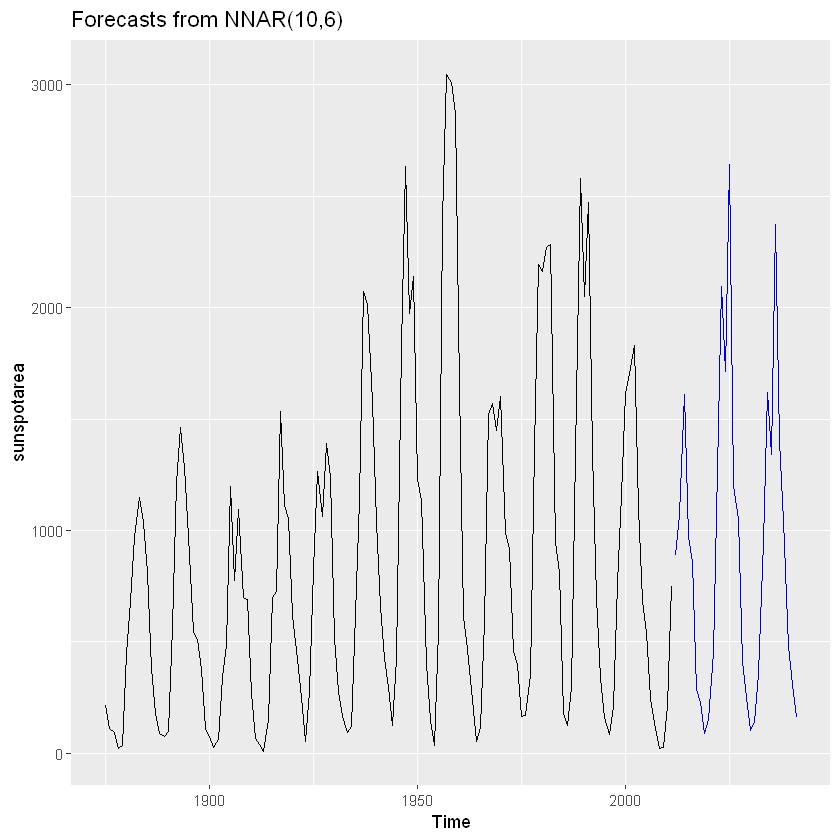

In [32]:
fit <- nnetar(sunspotarea, lambda=0)
autoplot(forecast(fit,h=30))

여기에서, 마지막 10개 관측값을 예측변수(predictor variable)로 사용했고, 숨겨진 계층에는 6개의 신경 세포가 있습니다. 데이터의 주기성(cyclicity; 또는 반복성)은 모델링이 잘 된 것을 확인할 수 있습니다. 모델이 반복되는 패턴의 비대칭성도 잡아내는 것도 확인할 수 있습니다. 여기에서 주기의 감소 부분보다 반복되는 패턴의 증가 부분이 더 가파릅니다. 이것은 NNAR 모델과 선형적인 AR 모델의 차이입니다. 선형적인 AR 모델로도 반복되는 패턴을 모델링할 수 있긴 합니다만, 모델링한 결과는 항상 대칭적입니다.

<br>

### 예측구간

이 책에서 다룬 대부분의 기법과는 다르게, 신경망은 잘 정의된 확률 모델에 기초하지 않습니다. 따라서 결과 예측값에 대한 예측구간(prediction interval)을 유도하는 것이 간단하지 않습니다. 하지만, 붓스트랩된 잔차(bootstraped residual)를 이용해서 만든 미래 표본 경로(future sample path)로 모사하면 예측구간을 얻을 수 있습니다(3.5 절에서 다룬 것처럼).

흑점 데이터에 맞춘 신경망 모델을 다음과 같이 쓸 수 있습니다.

$$y_t = f(\boldsymbol{y}_{t-1}) + \varepsilon_t$$


여기에서 $\boldsymbol{y}_{t-1} = (y_{t-1},y_{t-2},\dots,y_{t-10})'$은 시계열의 시차값을 담고 있는 벡터이고, $f$는 1개의 층에 6개의 숨은 마디가 있는 신경망입니다. 오차 시계열 $\{\varepsilon_t\}$의 분산이 균일하다고 (그리고 아마도 정규 분포를 따른다고) 가정합니다.

이 모델의 미래의 표본 경로를 정규 분포나 과거값에서 뽑는 방식으로  $\epsilon_t$에 대한 값을 무작위적으로 만들어서 반복적으로 모사할 수 있습니다. $\varepsilon^*_{T+1}$이 시간 $T+1$에서 오차의 분포로부터 무작위적으로 뽑은 것이라고 하면,

$$y^*_{T+1} = f(\boldsymbol{y}_{T}) + \varepsilon^*_{T+1}$$

은 $y_{T+1}$에 대한 예측분포로부터 뽑을 수 있는 하나의 가능한 값입니다. $\boldsymbol{y}_{T+1}^* = (y^*_{T+1}, y_{T}, \dots, y_{T-6})'$라고 두면, 아래의 값을 얻기 위해 이러한 과정을 반복할 수 있습니다.

$$y^*_{T+2} = f(\boldsymbol{y}^*_{T+1}) + \varepsilon^*_{T+2}.$$

이러한 방식으로, 미래의 표본 경로를 반복적으로 모사할 수 있습니다. 표본 경로를 반복적으로 모사하여, 맞춘 신경망에 기초하여 모든 미래값에 대한 분포를 만들어 나갈 수 있습니다.

아래는 흑점 데이터에 대한 가능한 9가지 미래 표본 경로(future sample path)를 모사한 것입니다. 각 표본 경로는 관측 데이터 이후 다음 20년에 해당합니다.



For a multivariate time series, specify a seriesname for each time series. Defaulting to column names.



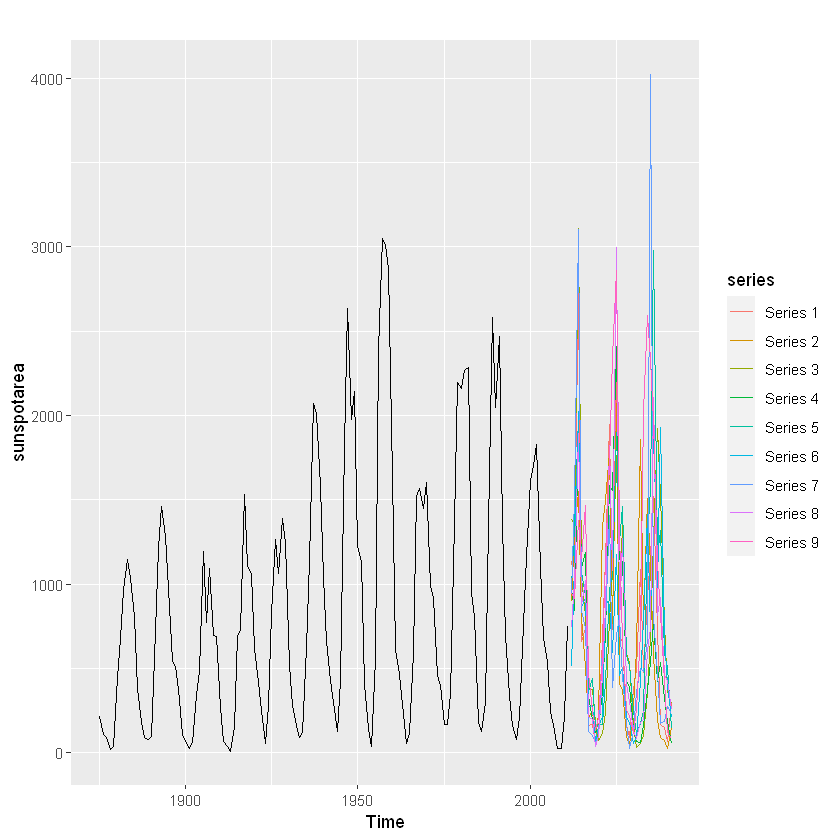

In [33]:
sim <- ts(matrix(0, nrow=30L, ncol=9L), 
  start=end(sunspotarea)[1L]+1L) 

for(i in seq(9)) 
  sim[,i] <- simulate(fit, nsim=30L)

autoplot(sunspotarea) + autolayer(sim)

이것을 수백 수천번 반복하면, 좋은 예측분포(forecast distribution) 그림을 얻을 수 있습니다. 이것이 `forecast()` 함수가 예측 구간을 내는 방식입니다:



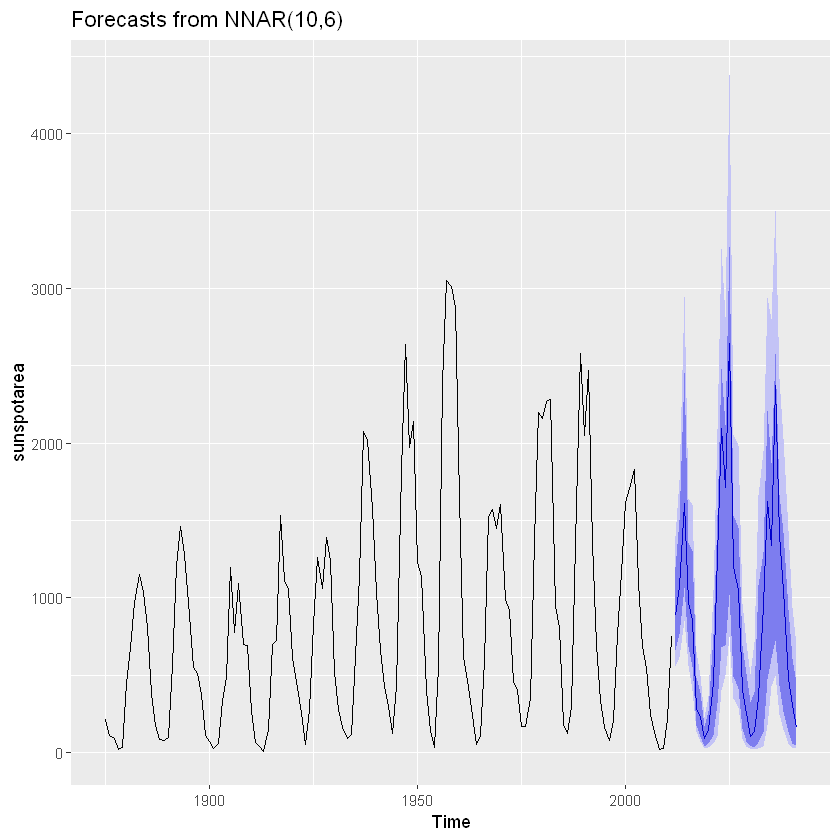

In [34]:
fcast <- forecast(fit, PI=TRUE, h=30) 

autoplot(fcast) 

위의 과정이 조금 느리기 때문에, `PI=FALSE`이 기본값입니다. 그래서 명시하지 않는 경우에는 예측 구간을 계산하지 않습니다. `forecast()`에서 입력값 `npaths`으로 모사를 얼마나 많이 할 것인지 조정합니다(기본값 1000). 기본적으로, 오차를 정규 분포에서 뽑습니다. 입력값 `ootstrap`은 과거 오차에서부터 무작위로 뽑아서 오차를 만들어내도록 합니다.



<br>

## 11.04. 붓스트랩과 배깅

### 시계열 붓스트랩

이전의 절과 3.5 절에서 모델을 가지고 어떤 한 시계열의 미래값을 모사하기 위해 시계열의 잔차를 어떻게 붓스트랩(bootstrap) 할 수 있는지 다루었습니다.

더욱 일반적으로, 다른 종류의 붓스트랩(bootstrap) 기법을 이용하여, 관찰한 시계열과 비슷한 새로운 시계열을 생성할 수 있습니다.

먼저, 시계열을 박스-칵스(Box-Cox) 변환합니다. 그리고 STL로 시계열을 추세, 계절성, 나머지 성분으로 분리합니다. 그러면 섞인 형태의 나머지 성분을 얻게 됩니다. 이는 붓스트랩한 나머지 성분 시계열을 얻기 위해 필요합니다. STL 나머지 성분 시계열에 자기상관값(autocorrelation)이 나타날 수 있기 때문에, 3.5 절에서 다룬 것처럼 단순하게 다시 그릴 수 없습니다. 대신에, “블록된 붓스트랩(blocked bootstrap)”을 사용합니다. 여기에서 시계열의 인접 부분은 무작위로 골라서 서로 붙인 것입니다. 이러한 붓스트랩된 나머지 시계열을 추세와 시계열 성분에 더하고, 원본 시계열의 변형된 형태를 얻기 위해 역 박스-칵스(reversed Box-Cox) 변환을 합니다.

이레 그림의 몇 가지 예제에서는 2000년 1월부터 2013년 8월까지 아이슬란드의 소매 직불 카드(retail debit card)의 월별 지출 데이터를 다룹니다.



For a multivariate time series, specify a seriesname for each time series. Defaulting to column names.



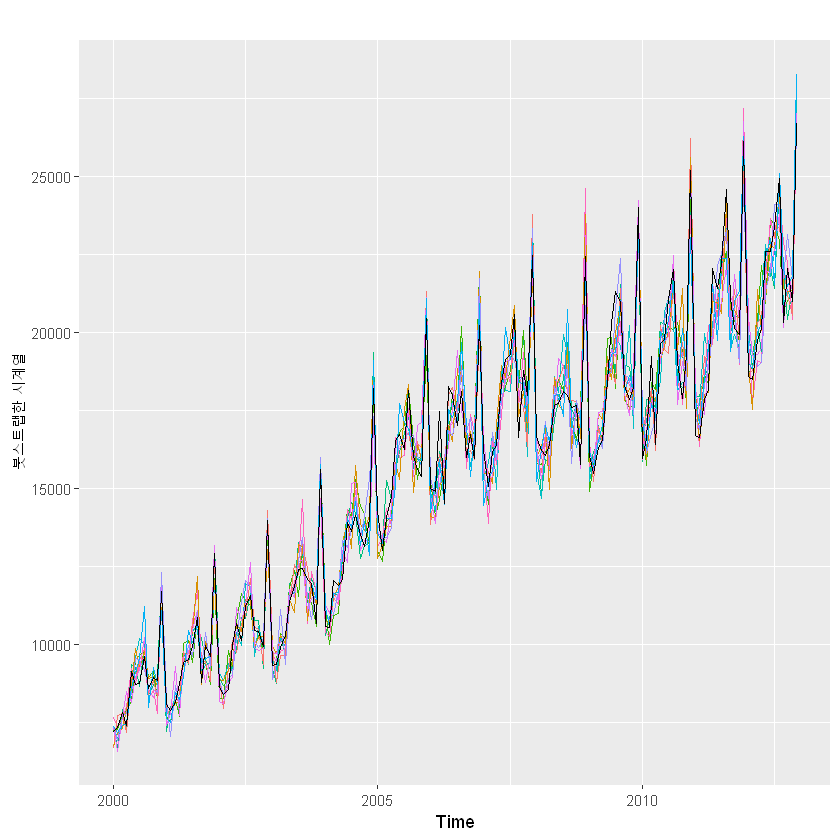

In [35]:
bootseries <- bld.mbb.bootstrap(debitcards, 10) %>%
  as.data.frame() %>% ts(start=2000, frequency=12)

autoplot(debitcards) +
  autolayer(bootseries, colour=TRUE) +
  autolayer(debitcards, colour=FALSE) +
  ylab("붓스트랩한 시계열") + guides(colour="none")

이러한 종류의 붓스트랩 기법은 두 가지 측면에서 유용합니다. 먼저, 이 방법으로 예측 불확실성을 더 잘 나타내는 측정값을 얻을 수 있습니다. 두 번째, 이 방법은 “배깅(bagging)”을 이용하여 점 예측값을 향상시키는 방법으로 이어집니다.

<br>

### 붓스트랩한 시계열에서 얻은 예측 구간

시계열 모델에서 얻는 거의 모든 예측구간(prediction interval)은 너무 좁습니다. 이러한 현상은 흔한 것이고 불확실성의 원인이 되는 모든 출처를 고려하지 않기 때문에 생기는 현상입니다. Hyndman, Koehler, Snyder, & Grose (2002) 에서 테스트 데이터에 대해 예측구간이 실제로 포괄하는 범위 비율을 계산하여 이러한 문제를 정량적으로 다룹니다. 이 논문에서는 ETS 모델에 대해 명목상의 95% 구간이 실제로는 71%에서 87% 정도 포괄할 수 있다는 것을 보입니다. 이 차이는 불확실성의 원인이 되는 출처를 빠뜨린 것에서 옵니다.

예측 작업에서 시계열 모델을 이용할 때 불확실성의 원인이 되는 적어도 4가지의 출처가 있습니다:

1. 무작위 오차 항;
2. 매개변수 추정;
3. 과거 데이터에 대해 모델을 선택할 것;
4. 과거 데이터의 연장선 상에서 미래 것을 생성하는 과정;

시계열 모델에 대해 예측 구간을 생성할 때, 일반적으로 1-3의 불확실성만 고려합니다. 모델의 불확실성(출처 3)과 데이터 생성 과정 변화 때문에 생기는 불확실성(출처 4)을 무시하고, 무작위 오차 항(출처 1)과 매개변수 불확실성(출처 2)만 허용하더라도, 몇 가지 특별히 단순한 경우를 제외하고는 대수적으로 해결할 수 있는 방법이 없습니다.

이러한 문제를 극복하는 몇 가지 방향으로 나아가기 위해 시계열을 붓스트랩하는 방법을 사용할 수 있습니다. debitcards 데이터를 이용하여 이러한 접근 방식을 설명해보겠습니다. 먼저, 위에서 다룬 블록-붓스트랩(block-bootstrap)을 이용하여 원본 데이터와 비슷한 여러 시계열을 모사하겠습니다.



In [36]:
nsim <- 1000L
sim <- bld.mbb.bootstrap(debitcards, nsim)

각각의 시계열에 대해, ETS 모델을 맞추고, 모델로부터 한 가지 표본 경로를 모사합니다. 다른 ETS 모델은 시계열이 비슷하기 때문에 같은 모델이 선택될 수도 있고, 각 경우에서 다른 ETS 모델이 선택될 수도 있습니다. 하지만, 추정한 매개변수를 다를 것입니다. 따라서 모사한 표본 경로에 오차항과 관련된 불확실성, 모델 불확실성, 매개변수 불확실성이 들어가게 될 것입니다. 이 방법은 모델로 많은 수의 시계열을 다루기 때문에 시간이 많이 걸립니다.



In [37]:
h <- 36L
future <- matrix(0, nrow=nsim, ncol=h)

for(i in seq(nsim))
  future[i,] <- simulate(ets(sim[[i]]), nsim=h)

마지막으로, 점 예측값과 예측 구간을 생성하기 위해 이러한 표본 경로의 평균과 분위수(quantile)값을 고려합니다.



In [38]:
start <- tsp(debitcards)[2]+1/12

simfc <- structure(list(
    mean = ts(colMeans(future), start=start, frequency=12),
    lower = ts(apply(future, 2, quantile, prob=0.025),
               start=start, frequency=12),
    upper = ts(apply(future, 2, quantile, prob=0.975),
               start=start, frequency=12),
  level=95),
  class="forecast")

이러한 예측 구간은 ETS 모델을 원본 데이터에 직접 적용하여 얻은 예측 구간보다 클 것입니다.




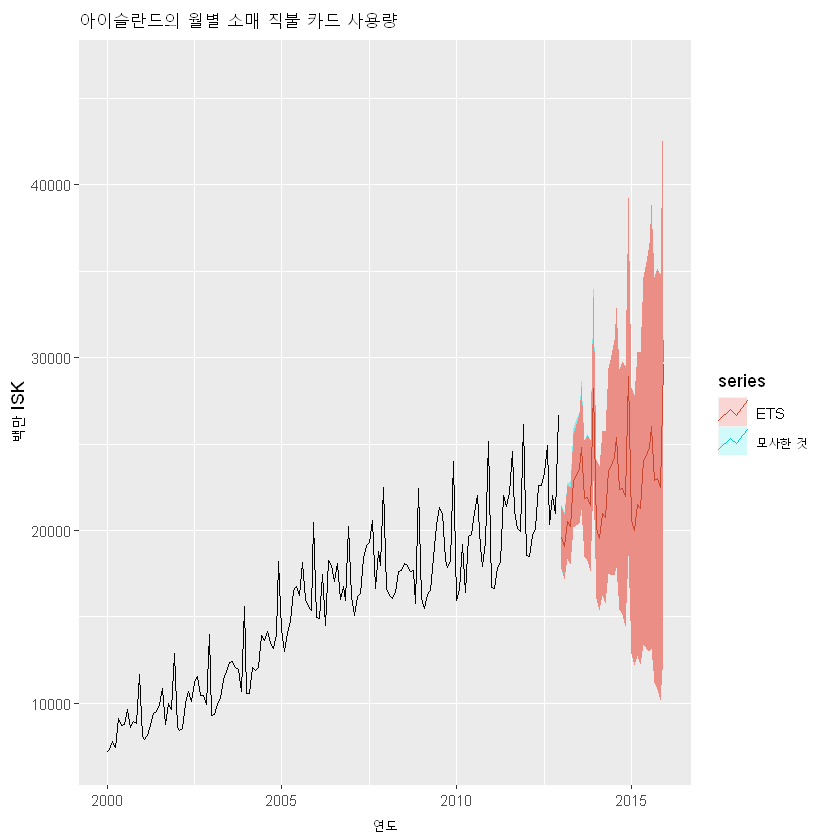

In [39]:
etsfc <- forecast(ets(debitcards), h=h, level=95)

autoplot(debitcards) +
  ggtitle("아이슬란드의 월별 소매 직불 카드 사용량") +
  xlab("연도") + ylab("백만 ISK") +
  autolayer(simfc, series="모사한 것") +
  autolayer(etsfc, series="ETS")

<br>

### 배깅한 ETS 예측


붓스트랩한 시계열을 예측 정확도를 높이는데 사용하기도 합니다. 각각의 추가적인 시계열에서 예측값을 내고 결과 예측값을 평균했다면, 원본 시계열에서 단순하게 직접 예측한 것보다 더 나은 예측값을 얻습니다. 이것을 “배깅(bagging)”이라고 부릅니다. “배깅(bagging)”은 “bootstrap aggregating”의 약자입니다.

이전에 계산하여 모사한 미래 표본 경로를 단순하게 평균할 수도 있을 것입니다. 하지만, 점 예측 정확도를 높이는 것에만 관심이 있고 향상된 예측 구간을 얻는 것에는 관심이 없다면, 각 시계열에서 얻은 점 예측값을 평균하면 더 빠릅니다. 모사할 여러 시계열을 생성할 필요가 없어서 계산이 빠르게 끝납니다.

각각의 시계열을 예측하기 위해 `ets()`을 사용하겠습니다. 아래 그림은 이러한 방법으로 얻은 10가지 예측값을 나타냅니다.



In [40]:
sim <- bld.mbb.bootstrap(debitcards, 10) %>%
  as.data.frame() %>%
  ts(frequency=12, start=2000)

fc <- purrr::map(as.list(sim),
           function(x){forecast(ets(x))[["mean"]]}) %>%
      as.data.frame() %>%
      ts(frequency=12, start=start)

For a multivariate time series, specify a seriesname for each time series. Defaulting to column names.

For a multivariate time series, specify a seriesname for each time series. Defaulting to column names.



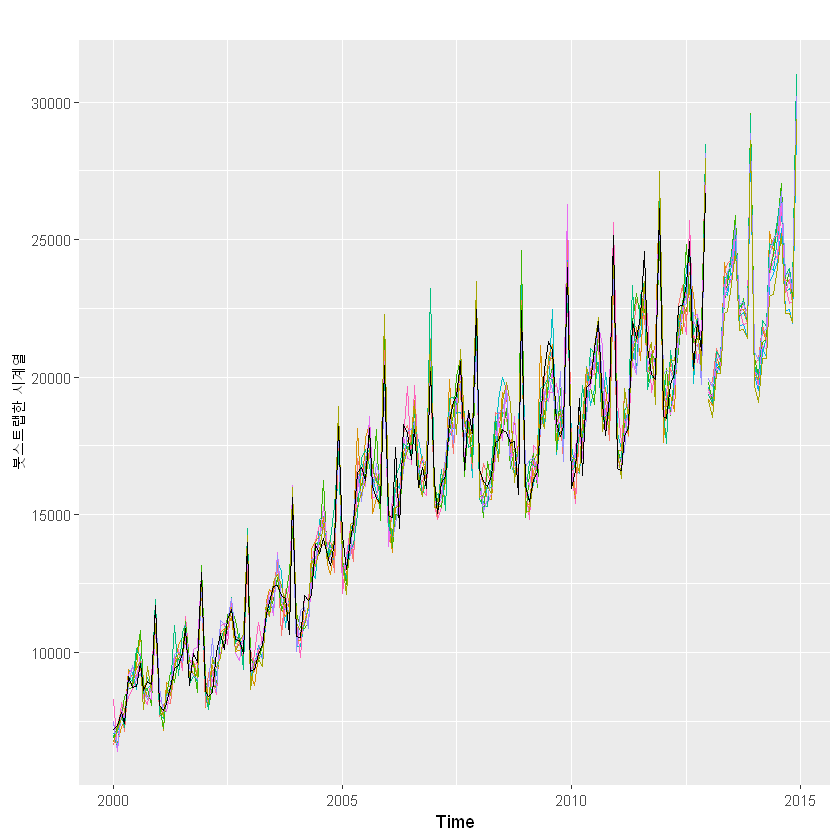

In [41]:
autoplot(debitcards) +
  autolayer(sim, colour=TRUE) +
  autolayer(fc, colour=TRUE) +
  autolayer(debitcards, colour=FALSE) +
  ylab("붓스트랩한 시계열") +
  guides(colour="none")

이러한 예측값의 평균은 원본 데이터를 배깅한 예측값입니다. baggedETS() 함수로 전체 과정을 다룰 수 있습니다. 기본값으로 붓스트랩하여 얻은 100개의 시계열을 사용하고, 붓스트랩한 잔차를 얻기 위한 블록(block)의 길이는 월별 데이터에 대해 24로 둡니다. 이레 그림은 결과 예측값을 나타냅니다.



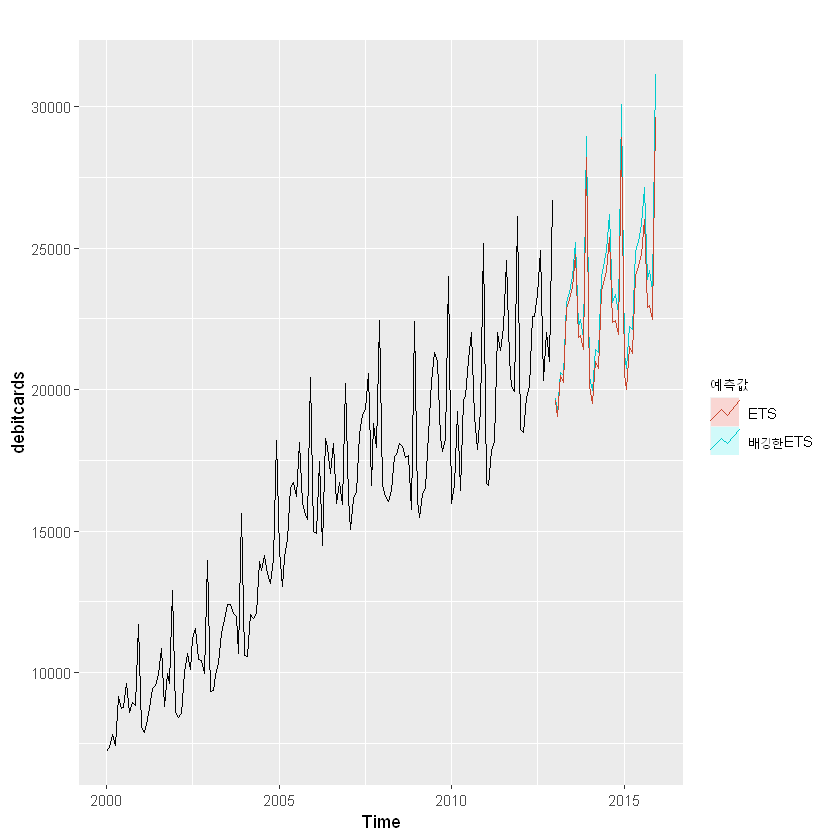

In [42]:
etsfc <- debitcards %>% ets() %>% forecast(h=36)
baggedfc <- debitcards %>% baggedETS() %>% forecast(h=36)

autoplot(debitcards) +
  autolayer(baggedfc, series="배깅한ETS", PI=FALSE) +
  autolayer(etsfc, series="ETS", PI=FALSE) +
  guides(colour=guide_legend(title="예측값"))

이 경우에는, 크게 차이나지 않습니다. Bergmeir, Hyndman, & Benítez (2016) 에서 ets()를 그냥 적용한 것보다 더 나은 예측값을 낸다는 것을 보였습니다. 물론, 더 많은 계산이 필요하기 때문에 더 느립니다.